<a href="https://colab.research.google.com/github/shubham123sing/Identifying-Flower-Species-using-Deep-Learning-and-PyTorch/blob/main/deep_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# deep-learning-project

Use the "Run" button to execute the code.

In [4]:
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('ld0al-ad0ekdAyEWqsJFbz54ChPh3p28j')


In [5]:
!pip install jovian --upgrade --quiet

## Identifying Flower Species using Deep Learning and PyTorch
1. Pick a dataset
2. Download the dataset
3. Import the dataset using PyTorch
4. Prepare the data set for training
5. Move the dataset to the GPU
6. Define a neural networks
7. Train the model
8. Make predictions on sample images lterate on it with different networks & hyperparameters.

### Download the Date set

using `opendatasets` and dowload the datasat from https://www.kaggle.com/alxmamaev/flowers-recognition .

In [6]:
!pip install opendatasets --upgrade --quiet

In [7]:
import opendatasets as od

In [8]:
dataset_url = 'https://www.kaggle.com/alxmamaev/flowers-recognition'

In [9]:
import os
import shutil
if os.path.exists('./flowers-recognition'):
    shutil.rmtree('./flowers-recognition')



In [10]:
od.download(dataset_url)

Dataset URL: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition


100%|██████████| 225M/225M [00:10<00:00, 22.5MB/s]


In [11]:
import os

In [12]:
data_dir = './flowers-recognition/flowers'

In [13]:
os.listdir(data_dir)

['sunflower', 'tulip', 'daisy', 'dandelion', 'rose']

In [14]:
for cls in os.listdir(data_dir):
    print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

sunflower : 733
tulip : 984
daisy : 764
dandelion : 1052
rose : 784


### Import the Datasat Into PyTorch

Use the `ImageFolder` class from `torchvision`.


In [15]:
from torchvision.datasets import ImageFolder

In [16]:
dataset = ImageFolder(data_dir)

In [17]:
len(  dataset)

4317

In [18]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=320x263>, 0)

In [19]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

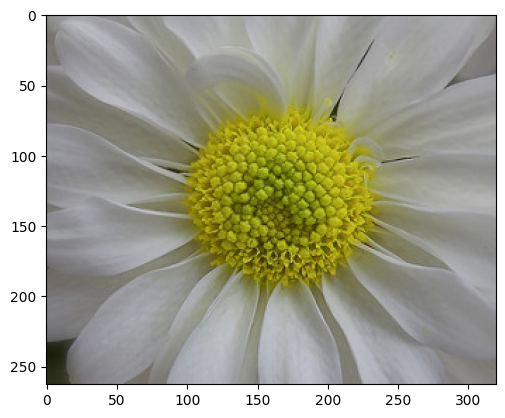

In [21]:
img, label = dataset[0]
plt.imshow(img)

In [22]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64),
                                            tt.RandomCrop(64),
                                            tt.ToTensor()]))

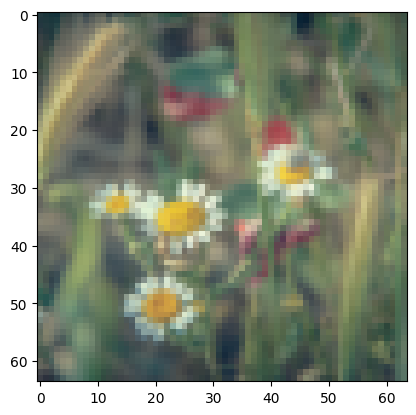

In [23]:
img, label = dataset[64]
plt.imshow(img.permute(1, 2, 0))

In [24]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(3886, 431)

In [25]:
from torch.utils.data import random_split

train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(3886, 431)

In [26]:
from torch.utils.data import DataLoader
batch_size = 128
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [27]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

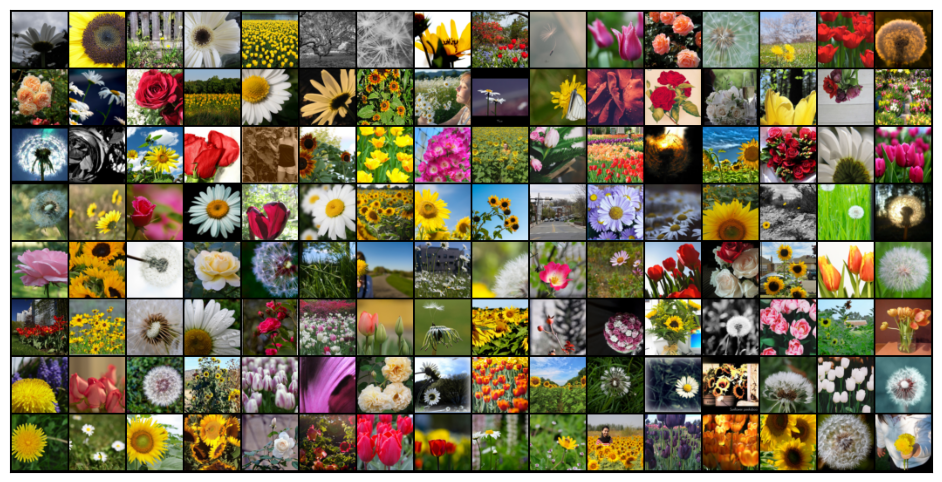

In [28]:
show_batch(train_dl)

### GPU Utilities

In [29]:
import torch
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [30]:
torch.cuda.is_available()

False

In [31]:
device = get_default_device()
device

device(type='cpu')

In [32]:
img, label = dataset[0]

In [33]:
img.device

device(type='cpu')

In [34]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cpu')

In [35]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

### Model and Training Utilties

In [36]:
import torch.nn as nn
import torch.nn.functional as F
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


In [37]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Model

In [38]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 32)
        self.conv2 = conv_block(32, 64, pool=True)
        self.res1 = nn.Sequential(conv_block(64, 64),
                                  conv_block(64, 64))

        self.conv3 = conv_block(64, 128, pool=True) # Changed the output channels to 128 to match conv4
        self.conv4 = conv_block(128, 128, pool=True)
        self.res2 = nn.Sequential(conv_block(128, 128),
                                  conv_block(128, 128))

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(128, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [39]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    

In [40]:
model.conv1[0].weight.device


device(type='cpu')

Pass one batch of input tensor through the model.

In [41]:
import torch
torch.cuda.empty_cache()
for batch in train_dl:
    images, labels = batch
    print('images.shape:', images.shape)
    print('images.device:', images.device)
    preds = model(images)
    print('preds.shape:', preds.shape)
    break

images.shape: torch.Size([128, 3, 64, 64])
images.device: cpu
preds.shape: torch.Size([128, 5])


### Traning

In [42]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.7147669792175293, 'val_acc': 0.1881808042526245}]

In [43]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], val_loss: 1.2400, val_acc: 0.5125
Epoch [1], val_loss: 1.1371, val_acc: 0.5653
Epoch [2], val_loss: 1.0607, val_acc: 0.5790
Epoch [3], val_loss: 0.9981, val_acc: 0.6313
Epoch [4], val_loss: 0.8825, val_acc: 0.6665


In [44]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], val_loss: 0.9438, val_acc: 0.6250
Epoch [1], val_loss: 0.8607, val_acc: 0.6686
Epoch [2], val_loss: 0.8175, val_acc: 0.6801
Epoch [3], val_loss: 0.7590, val_acc: 0.7117
Epoch [4], val_loss: 0.7302, val_acc: 0.7089


In [45]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], val_loss: 0.7542, val_acc: 0.7221
Epoch [1], val_loss: 0.7973, val_acc: 0.7204
Epoch [2], val_loss: 0.8259, val_acc: 0.7025
Epoch [3], val_loss: 0.7365, val_acc: 0.7367
Epoch [4], val_loss: 0.8031, val_acc: 0.7216


In [46]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], val_loss: 0.7457, val_acc: 0.7282
Epoch [1], val_loss: 0.7060, val_acc: 0.7330
Epoch [2], val_loss: 0.7283, val_acc: 0.7294
Epoch [3], val_loss: 0.7685, val_acc: 0.7341
Epoch [4], val_loss: 0.7870, val_acc: 0.7350


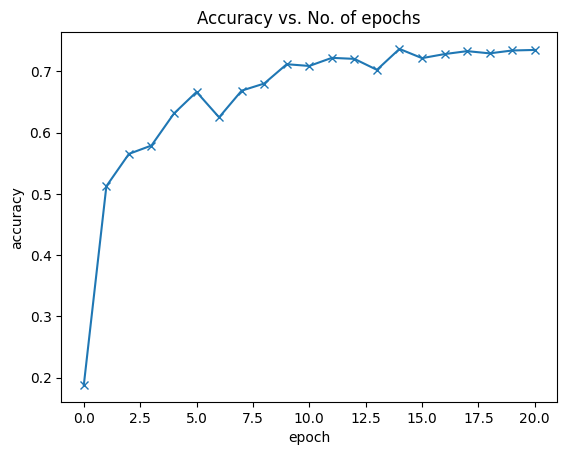

In [47]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

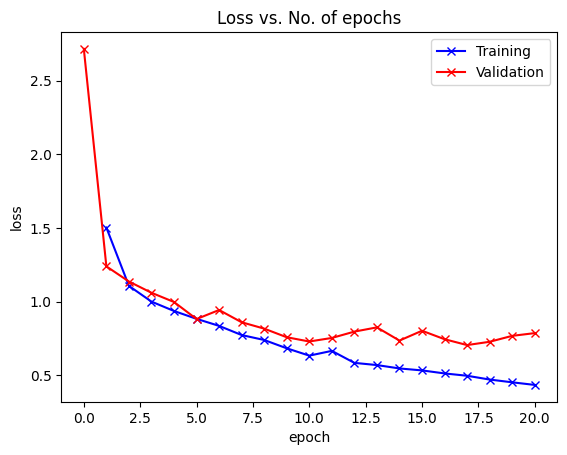

In [48]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

### Record the Results

In [49]:
history[-1]

{'val_loss': 0.7870362997055054,
 'val_acc': 0.7350000143051147,
 'train_loss': 0.43564221262931824}

In [50]:
jovian.reset()
jovian.log_dataset(image_size=64)
jovian.log_hyperparams(batch_size=128,arch='ResNet9',
                       epochs=[5,5,5,5],lrs=[0.001,0.001,0.001,0.001],
                       opt=['Adam','Adam','Adam','SGD'])
jovian.log_metrics(train_loss=history[-1]['train_loss'], # Removed newline and added comma
                   val_loss=history[-1]['val_loss'],
                   val_acc=history[-1]['val_acc'])

[jovian] Dataset logged.
[jovian] Hyperparams logged.
[jovian] Metrics logged.


### Test with Individual Images

In [51]:
def predict_image(img, model,classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [52]:
def show_image_prediction(img, label):
    plt.imshow(img.permute((1, 2, 0)))
    pred = predict_image(img, model,dataset.classes)
    print('Target:', dataset.classes[label])
    print('Prediction:', pred)

In [ ]:
show_image_prediction(*valid_ds[500])

Target: tulip
Prediction: tulip


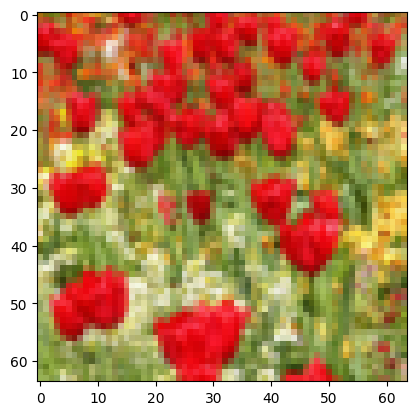

In [54]:
show_image_prediction(*valid_ds[300])

Target: rose
Prediction: tulip


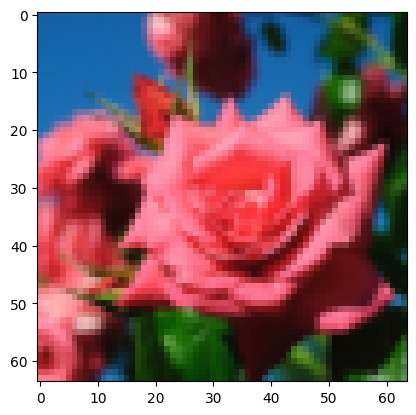

In [55]:
show_image_prediction(*valid_ds[100])

In [56]:
torch.save(model.state_dict(), 'flowers-resnet9.pth')

## Tranfer Learning

In [57]:
from torchvision import models

class ResNet34(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [58]:
model = to_device(ResNet34(len(dataset.classes),pretrained=True), device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [59]:
model

ResNet34(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [60]:
import torchvision.transforms as tt

img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(img_size),
                                            tt.RandomCrop(img_size),
                                            tt.ToTensor(),
                                            tt.Normalize(*imagenet_stats)]))

In [61]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=4, pin_memory=True)

In [62]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [63]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [64]:
model = to_device(ResNet34(len(dataset.classes),pretrained=True), device)

In [65]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.7734756469726562, 'val_acc': 0.19880318641662598}]

In [1]:
history += fit_one_cycle(8, 0.001, model, train_dl, valid_dl, grad_clip=0.1, weight_decay=1e-4,opt_func=torch.optim.Adam)

In [2]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [3]:
plot_accuracies(history)

NameError: name 'history' is not defined

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
plot_losses(history)

In [ ]:
import numpy as np
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

In [ ]:
plot_lrs(history)

In [ ]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

In [ ]:
img, label = valid_ds[0]
show_image(img, label)
predict_image(img, model,dataset.classes)
print('predicted',pred)